# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Load and Inspect Dataset**

In [2]:
df = pd.read_csv("../data/ai_job_market_insights.csv")

df.head()

,Job_Title,Industry,Company_Size,Location,AI_Adoption_Level,Automation_Risk,Required_Skills,Salary_USD,Remote_Friendly,Job_Growth_Projection
0,Cybersecurity Analyst,Entertainment,Small,Dubai,Medium,High,UX/UI Design,111392.165243,Yes,Growth
1,Marketing Specialist,Technology,Large,Singapore,Medium,High,Marketing,93792.562466,No,Decline
2,AI Researcher,Technology,Large,Singapore,Medium,High,UX/UI Design,107170.263069,Yes,Growth
3,Sales Manager,Retail,Small,Berlin,Low,High,Project Management,93027.953758,No,Growth
4,Cybersecurity Analyst,Entertainment,Small,Tokyo,Low,Low,JavaScript,87752.922171,Yes,Decline


# **Dataset Information**

In [3]:
df.info()

print(f"Null Rows:\n{df.isnull().sum()}")

print(f"Duplicated Rows: {df.duplicated().sum()}")

print(f"Describe:\n{df.describe()}")

print(f"Shape: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Job_Title              500 non-null    object 
 1   Industry               500 non-null    object 
 2   Company_Size           500 non-null    object 
 3   Location               500 non-null    object 
 4   AI_Adoption_Level      500 non-null    object 
 5   Automation_Risk        500 non-null    object 
 6   Required_Skills        500 non-null    object 
 7   Salary_USD             500 non-null    float64
 8   Remote_Friendly        500 non-null    object 
 9   Job_Growth_Projection  500 non-null    object 
dtypes: float64(1), object(9)
memory usage: 39.2+ KB
Null Rows:
Job_Title                0
Industry                 0
Company_Size             0
Location                 0
AI_Adoption_Level        0
Automation_Risk          0
Required_Skills          0
Salary_USD        

In [4]:
print(f"Number of Unique: {df["Job_Title"].nunique()}")
print(f"Number of Unique: {df["Industry"].nunique()}")
print(f"Number of Unique: {df["Company_Size"].nunique()}")
print(f"Number of Unique: {df["Location"].nunique()}")
print(f"Number of Unique: {df["AI_Adoption_Level"].nunique()}")
print(f"Number of Unique: {df["Automation_Risk"].nunique()}")
print(f"Number of Unique: {df["Required_Skills"].nunique()}")
print(f"Number of Unique: {df["Salary_USD"].nunique()}")
print(f"Number of Unique: {df["Remote_Friendly"].nunique()}")
print(f"Number of Unique: {df["Job_Growth_Projection"].nunique()}")

Number of Unique: 10
Number of Unique: 10
Number of Unique: 3
Number of Unique: 10
Number of Unique: 3
Number of Unique: 3
Number of Unique: 10
Number of Unique: 500
Number of Unique: 2
Number of Unique: 3


# **Salary Distribution**

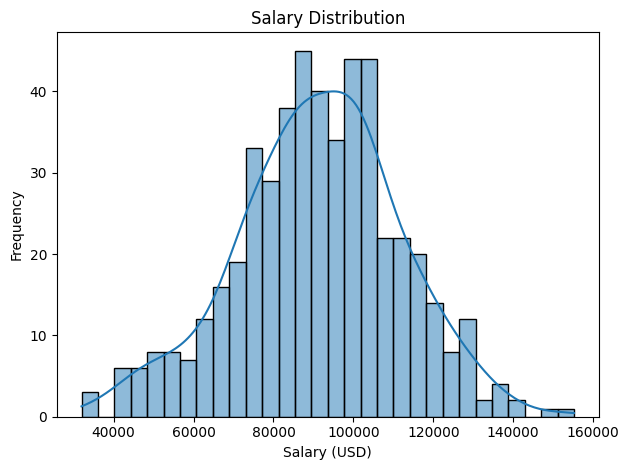

In [13]:
sns.histplot(df['Salary_USD'], bins=30, kde=True)
plt.title("Salary Distribution")
plt.xlabel("Salary (USD)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("../assets/images/salary_distribution.png")
plt.show()

# **Job Count by Industry**

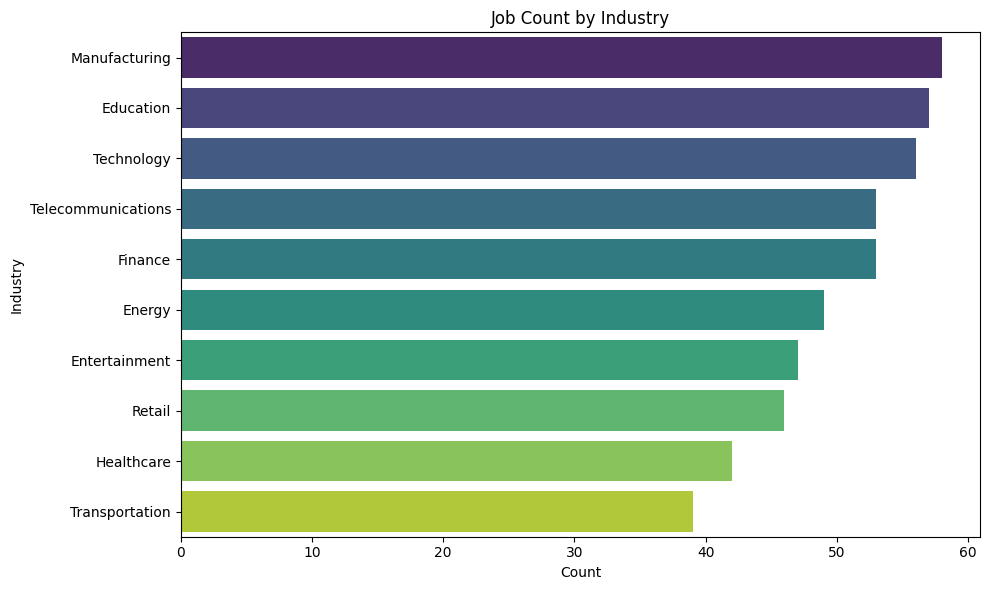

In [25]:
plt.figure(figsize=(10, 6))
industry_counts = df["Industry"].value_counts()
sns.barplot(x=industry_counts.values, y=industry_counts.index, palette="viridis", hue=industry_counts.index)
plt.title("Job Count by Industry")
plt.xlabel("Count")
plt.ylabel("Industry")
plt.tight_layout()
plt.savefig("../assets/images/industry_barh.png")
plt.show()


# **AI Adoption Level Distribution**

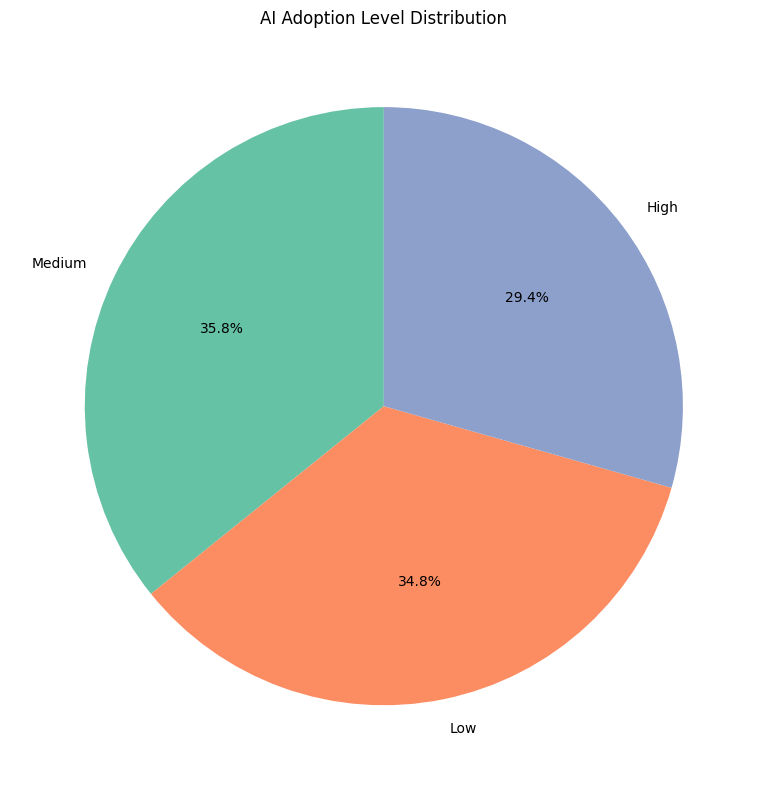

In [26]:
plt.figure(figsize=(8, 8))
ai_adoption_counts = df["AI_Adoption_Level"].value_counts()
sns.set_palette("Set2")
ai_adoption_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=False)
plt.title("AI Adoption Level Distribution")
plt.ylabel('')
plt.tight_layout()
plt.savefig("../assets/images/ai_adoption_pie.png")
plt.show()

# **Salary vs Company Size**

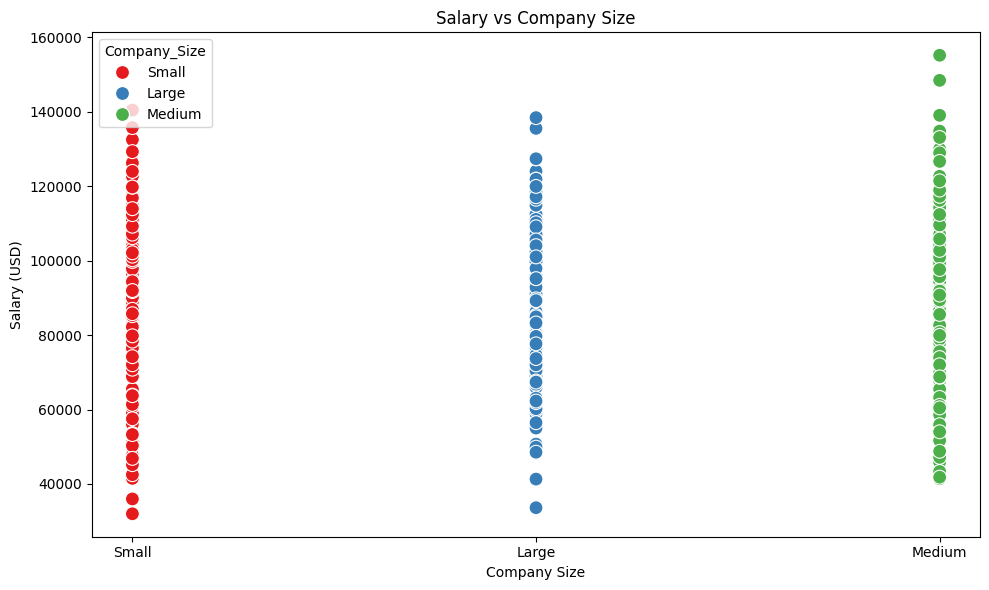

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Company_Size', y='Salary_USD', data=df, hue='Company_Size', palette="Set1", s=100)
plt.title("Salary vs Company Size")
plt.xlabel("Company Size")
plt.ylabel("Salary (USD)")
plt.tight_layout()
plt.savefig("../assets/images/salary_vs_company_size_scatter.png")
plt.show()

# **Salary Distribution by Industry**

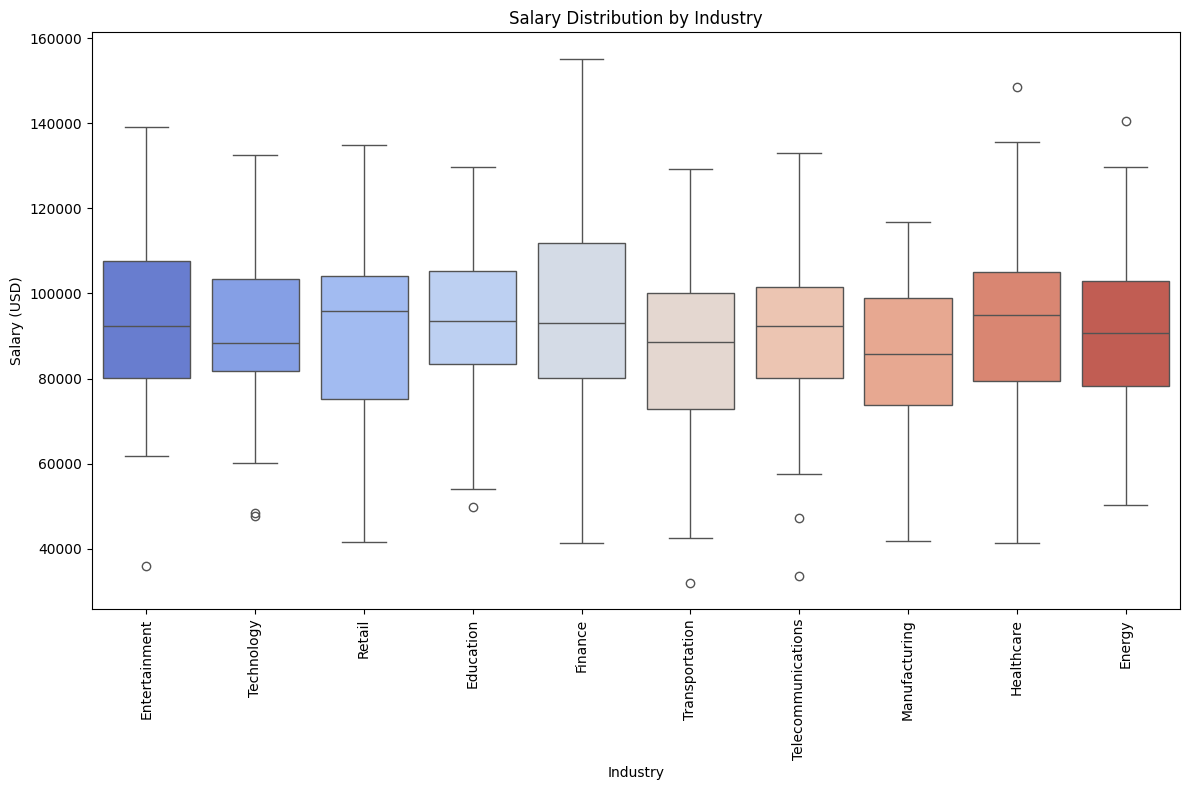

In [33]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Industry', y='Salary_USD', data=df, palette="coolwarm", hue='Industry')
plt.title("Salary Distribution by Industry")
plt.xlabel("Industry")
plt.ylabel("Salary (USD)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../assets/images/salary_distribution_by_industry.png")
plt.show()